<table>
    <tr style="background-color:white;">
        <td width="60%">
            <div style="height: 25px;"></div>
            <div align="left" style="color: #4b324e; font-size: 40px; font-weight: bold;">Taller de Qiskit</div>
        </td>
        <td>
            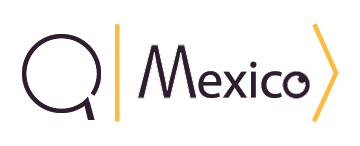
        </td>
    </tr>
</table>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

<div align="center" style="color: #EE2A6F; font-size: 30px; font-weight: bold;"> Caracterización: Error ZZ </div>

<div align="right" style="font-size: 15px; font-weight: normal;">Preparado por Bruno Ramírez</div>

<a href="https://opensource.org/licenses/Apache-2.0"></a>

# Contenido

1. [Introducción](#intro)
2. [Qubits superconductores, acoplamiento y errores](#secc1)
   1. [Error provocado por acoplamiento](#secc1.1)
   2. [Desplazamiento de energía](#secc1.2)
   3. [Determinación experimental de el error ZZ](#secc1.3)
4. [Herramientas de Qiskit para medir el error ZZ](#secc2)
3. [Después de la caracterización](#secc3)


<a id="intro"></a>
# Introducción

Recordemos que en computación cuántica se deben considerar errores debido a la aplicación de compuertas, a la medición de los estados finales, y a las características inherentes del sistema cuántico. En este notebook nos interesamos por primera vez en este último rubro, es decir, la construcción del qubit _per se_. El error que estudiaremos es específico de los sistemas de __dos qubits superconductores, conocido como error ZZ__.


<div class="alert alert-block alert-success">

**Importante: Teoría avanzada**

Este notebook está íntimamente relacionado con la teoría especializada acerca de qubits superconductores conocida como cQED. En esta teoría se hace uso de conceptos avanzados de mecánica cuántica fuera del alcance de este curso. Procuraré mostrar las implicaciones fenomenológicas de esta teoría, relevando los detalles matemáticos a fuentes externas. ¡Revisa los enlaces en el texto! Un buen punto de inicio en la teoría de cQED y qubits tipo transmon es [este capítulo](https://qiskit.org/textbook/ch-quantum-hardware/index-pulses.html) del libro de texto de Qiskit.

</div>

In [1]:
# Herramientas de Python auxiliares a Qiskit
import numpy as np
import matplotlib.pyplot as plt

# Herramientas de Qiskit necesarias para crear modelos de ruido
import qiskit
from qiskit.providers.aer.noise.errors.standard_errors import coherent_unitary_error
from qiskit.providers.aer.noise import NoiseModel

# Herramientas de Qiskit Ignis a utilizar
from qiskit.ignis.characterization.hamiltonian import ZZFitter, zz_circuits

<a id="secc1"></a>
# Qubits superconductores, acoplamiento y errores

Los procesadores cuánticos que diseña IBM son de un tipo específico llamados qubits superconductores tipo transmon. Para llevar a cabo los algoritmos cuánticos esenciales se requieren de la interacción entre múltiples qubits. Por lo general, los qubits están separados por distancias que les impiden interactuar entre sí. Esta interacción entre qubits lejanos, se lleva a cabo [insertando cavidades de microondas](https://www.nature.com/articles/nature06184?error=cookies_not_supported&code=c7aca801-6a23-45ec-9603-fcd82aa37b0b). A través de estas cavidades es posible afectar el estado de un qubit lejano a través del intercambio de fotones en la cavidad.


Adelante se muestra un esquema de dos qubits que interactúan mediante una cavidad resonante. 

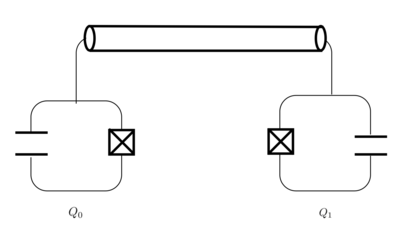
<a id="secc1.1"></a>
## Error provocado por acoplamiento

El acoplamiento entre qubits, aún cuando es fundamental para ejecutar circuitos cuánticos, genera algunos problemas. En particular el acoplamiento genera interacciones no deseadas entre el estado de dos qubits excitados $\ket{11}$ y otros [estados superiores del qubit superconductor](https://qudev.phys.ethz.ch/static/content/courses/QSIT09/presentations/PakrouskiPechal.pdf) ($\ket{02}, \ket{20}$). Estos últimos estados existen debido a que los qubits tipo transmon no son sistemas cuánticos de dos niveles perfectos, sino osciladores 
anharmónicos. 

La interacción entre el estado $\ket{11}$ y otros niveles se identifica como error $ZZ$, esto provoca un desplazamiento del la energía del estado correspondiente ambos qubits excitados. Lo malo de este error es que genera __entrelazamiento no deseado__ entre pares de qubits. Para más detalles puedes revisar este par de artículos: [(1)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.200504), [(2)](https://arxiv.org/pdf/2011.03976.pdf). 



<a id="secc1.2"></a>
## Desplazamiento de energía

Por simplicidad entenderemos al error ZZ como un desplazamiento en la energía que corresponde al estado con ambos qubits excitados, $\ket{11}$, esto puede observarse en el el siguiente Hamiltoniano en la presencia del término $\xi$, véase [[3]](#ref3).

$$ H=\omega_0 (1-\sigma_{Z,0})/2 +\omega_1 (1-\sigma_{Z,1})/2 + \xi |11\rangle\langle 11| $$ 

El término $\xi$ es un cuantificador del error ZZ, el cual puede ser calculado empíricamente mediante el cálculo de las frecuencias de oscilación de ambos qubits en distintos estados. Viendo el siguiente esquema de energías, podemos calcular el desplazamiento de energía a partir de las frecuencias.

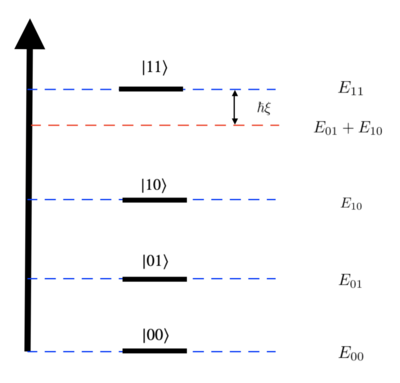

$$\hbar\xi = E_{11} - (E_{01}+E_{01}) = \hbar(\omega_{11} - \omega_
{Q0}-\omega_{Q1})$$

$$\xi = \omega_{11} - \omega_
{Q0}-\omega_{Q1}$$

Por lo general se le conoce a $\xi$ como "Parámetro ZZ" o "Razón ZZ".

<a id="secc1.3"></a>
## Determinación experimental del error ZZ

Para caracterizar el error ZZ bastará con determinar las frecuencias de oscilación de cada qubit en distintos estados y calcular $\xi$. Para esto se hacen [pulsos de Ramsey](https://qudev.phys.ethz.ch/static/content/QIPII18/ExerciseClass/Potocnik/pres1.pdf) en el qubit $Q_0$ en dos condiciones distintas: cuando el qubit $Q_1$ está en el estado base, y cuando $Q_1$ se encuentra en el estado excitado. Los pulsos de Ramsey son del tipo $H - t - H$, donde $t$ denota un tiempo de espera. 



Adelante definimos un modelo de error que simula la aparición del error ZZ en un dispositivo real.

In [2]:
# Modelo de ruido, error ZZ

zz_unitary = np.eye(4,dtype=complex)
zz_unitary[3,3] = np.exp(1j*2*np.pi*0.02*0.1)
error = coherent_unitary_error(zz_unitary)
zz_noise_model = NoiseModel()
zz_noise_model.add_nonlocal_quantum_error(error, 'zz', [0], [0,1])

<a id="secc2"></a>
# Herramientas de Qiskit para medir el error ZZ

### Función:  `t1_circuits(num_of_gates, gate_time, qubits)`:
> __¿Qué hace?__: Proporciona los circuitos necesarios para medir $\xi$. Cada circuito aplica una compuerta $H$, espera una cantidad creciente de tiempo aplicando cada vez más compuertas identidad ($\mathbb{I}$). También aplica una compuerta de fase que induce una oscilación. Posteriormente aplica otra compuerta $H$ y mide el estado. Se hace esto dos veces por circuito, cuando el qubit espectador se encuentra en $\ket{0}$ y posteriormente en $\ket{1}$
    
> __¿Qué argumentos toma?__ 
- ``num_of_gates(Union[List[int], np.array])``: Lista o arreglo de números enteros que indica la cantidad de compuertas identidad a aplicar en cada circuito.
- ``gate_time(float)``: Tiempo que tardará en ejecutar cada compuerta identidad.
- ``qubits(List[int])``: Lista de índices que indica a qué qubits se les medirá $\xi$. Se harán secuencias de Ramsey sobre este qubit.
- `spectators(List[int])`: Lista de índices que indica qué qubits se les volteará el estado de $\ket{0}$ a $\ket{1}$, debe tener la misma longitud que `qubits`.
- ``nosc(int)``: Número de oscilaciones que inducirá la compuerta de fase aplicada.
    
> __¿Qué devuelve?__: Devuelve con tres objetos: un `QuantumCircuit`, un `array` y un `float`. El primero de ellos es una lista de los circuitos cuánticos a ejecutar, el segundo es una lista con los datos de tiempo de espera, y el tercero es el valor de la frecuencia de oscilación inducida.

### Clase:  `T1Fitter(backend_result , xdata, qubits, fit_p0, fit_bounds )`:
>__¿Qué hace?__: Crea un objeto que usa los circuitos generados por la función anterior, hace un ajuste de los datos a funciones de tipo coseno $A\cos(\omega t + \phi)$ y $C\sin(\omega t + \phi)$. 

>__¿Qué parámetros de construcción tiene?__       
- ``backend_result(Result)``: Objeto de la clase Result en Qiskit, resultado de correr los circuitos de  `zz_circuits()` con un _backend_ seleccionado.
- ``xdata(Union[List[float], np.array])``: Lista de tiempos de retardo generada al crear los circuitos.
- ``qubits(List[int])``: Lista de índices que indica a qué qubits se les medirá $\xi$. 
- ``fit_p0(List[float])``: Valores iniciales para las variables de ajuste $A, C, \omega, \phi$
- ``fit_bounds(Tuple[List[float],List[float]])``: Cotas para los posibles valores del ajuste. La primera lista indica cotas inferiores para cada variable, la segunda lista indica las cotas superiores.


>__¿Qué construye?__: Construye un objeto que contiene los datos de las variables ajustadas, entre ellos contiene un valor de $\omega$ para cada oscilación ajustada, lo cual permite calcular el parámetro $\xi$. Se proporciona un valor calculado del parámetro ZZ para el j-ésimo qubit, $\xi_j$ ,mediante `zzfit.ZZ_rate()[j]`. Este objeto incluye un método para graficar los datos de población del estado excitado en cada experimento de Ramsey mediante ``zzfit.plot_ZZ()``.



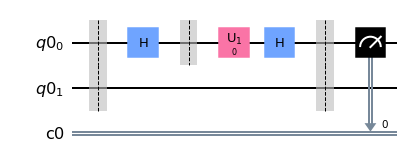

In [3]:
# Seleccionar los qubits a los que se les medirá el parámetro ZZ
qubits = [0]
espectador = [1]

num_of_gates = np.arange(0,150,5)

################
# zz_ circuits #
################

zz_circs, xdata, osc_freq = zz_circuits(num_of_gates, 0.1, qubits, espectador, nosc=2)

zz_circs[0].draw(output = "mpl")

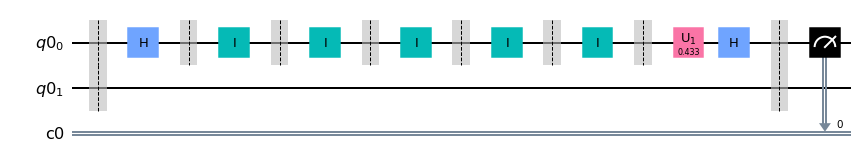

In [4]:
zz_circs[1].draw(output = "mpl")

In [5]:
# Ejecutamos nuestros circuitos en el backend de preferencia
# En este caso el backend es el simulador con el modelo de ruido para el error ZZ

backend = qiskit.Aer.get_backend('qasm_simulator')

backend_result = qiskit.execute(zz_circs, backend,
                                shots=500, noise_model=zz_noise_model, optimization_level = 0).result()

El error ZZ está caracterizado por un desplazamiento energético de: 0.526601 kHz


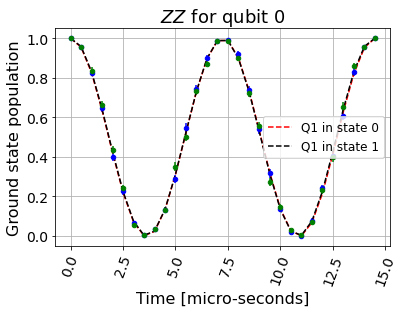

In [6]:
# Parámetros iniciales para el ajuste de oscilación 
p0_a = 1
p0_c = 0
p0_f = osc_freq #Frecuencia proporcionada por la función zz_circuits()
p0_phi = -np.pi/20

############
# ZZFitter #
############

fit = ZZFitter(backend_result, xdata, qubits, espectador,
                   fit_p0=[p0_a, p0_f, p0_phi, p0_c],
                   fit_bounds=([-0.5, 0, -np.pi, -0.5],
                               [1.5, 2*osc_freq, np.pi, 1.5]))

fit.plot_ZZ(0)

print("El error ZZ está caracterizado por un desplazamiento energético de: %f kHz"%(fit.ZZ_rate()[0]*1e3))
plt.show()

<a id="secc3"></a>
# Después de la caracterización

El trabajo hecho durante éste  notebook solamente nos permite caracterizar la presencia de errores, es decir, tomar medida de que tanto afecta el error ZZ a nuestros qubits. El error ZZ puede ser mitigado modificando el esquema y parámetros de acoplamiento y otros parámetros físicos del qubit tipo transmon o incluso cambiando hacia otro modelo de qubit distinto del transmon, por ejemplo el [CSFQ](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.200504). 

<a id="secc3"></a>
# Referencias
***
- [1] Qiskit Development Team. Tutorial: Hamiltonian and Gate Characteriztion. Consultado en https://github.com/Qiskit/qiskit-tutorials/blob/9405254b38312771f8d5c2dd6f451cec35307995/tutorials/noise/1_hamiltonian_and_gate_characterization.ipynb
- [2] Qiskit Development Team. Characterization (qiskit.ignis.characterization). Consultado en https://qiskit.org/documentation/apidoc/characterization.html
<a id="ref3"></a>
- [3] McKay, D. Hamiltonian Parameters. Consultado en https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/ignis/hamiltonian.ipynb

<table width="100%">
    <tr style="background-color:white;">
        <td>
            <div style="text-align: left;">
            <a href="01_Errores_en_Compuertas.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                &lt;&lt; Notebook anterior: 01_Errores_en_Compuertas
            </a>
            </div>
        </td>
        <td>
            <div style="text-align: right;">
            <a href="03_Relajacion_y_Decoherencia.ipynb" style="color: #EE2A6F; font-size: 15px; font-weight: normal;">
                Notebook siguiente: 03_Relajacion_y_Decoherencia >>
            </a>
            </div>
        </td>
    </tr>
</table>